# MMM Example Notebook

In this notebook we work out a simulated example to showcase the MMM API from `pymc-marketing`. The data generation process is as an adaptation of the blog post [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

---
# Part I: Data Generation Process

For this example we use simulated data.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import MaxAbsScaler,  MinMaxScaler
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

### 1. Date Range

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]

### 2. Media Costs Data

- Raw Signal

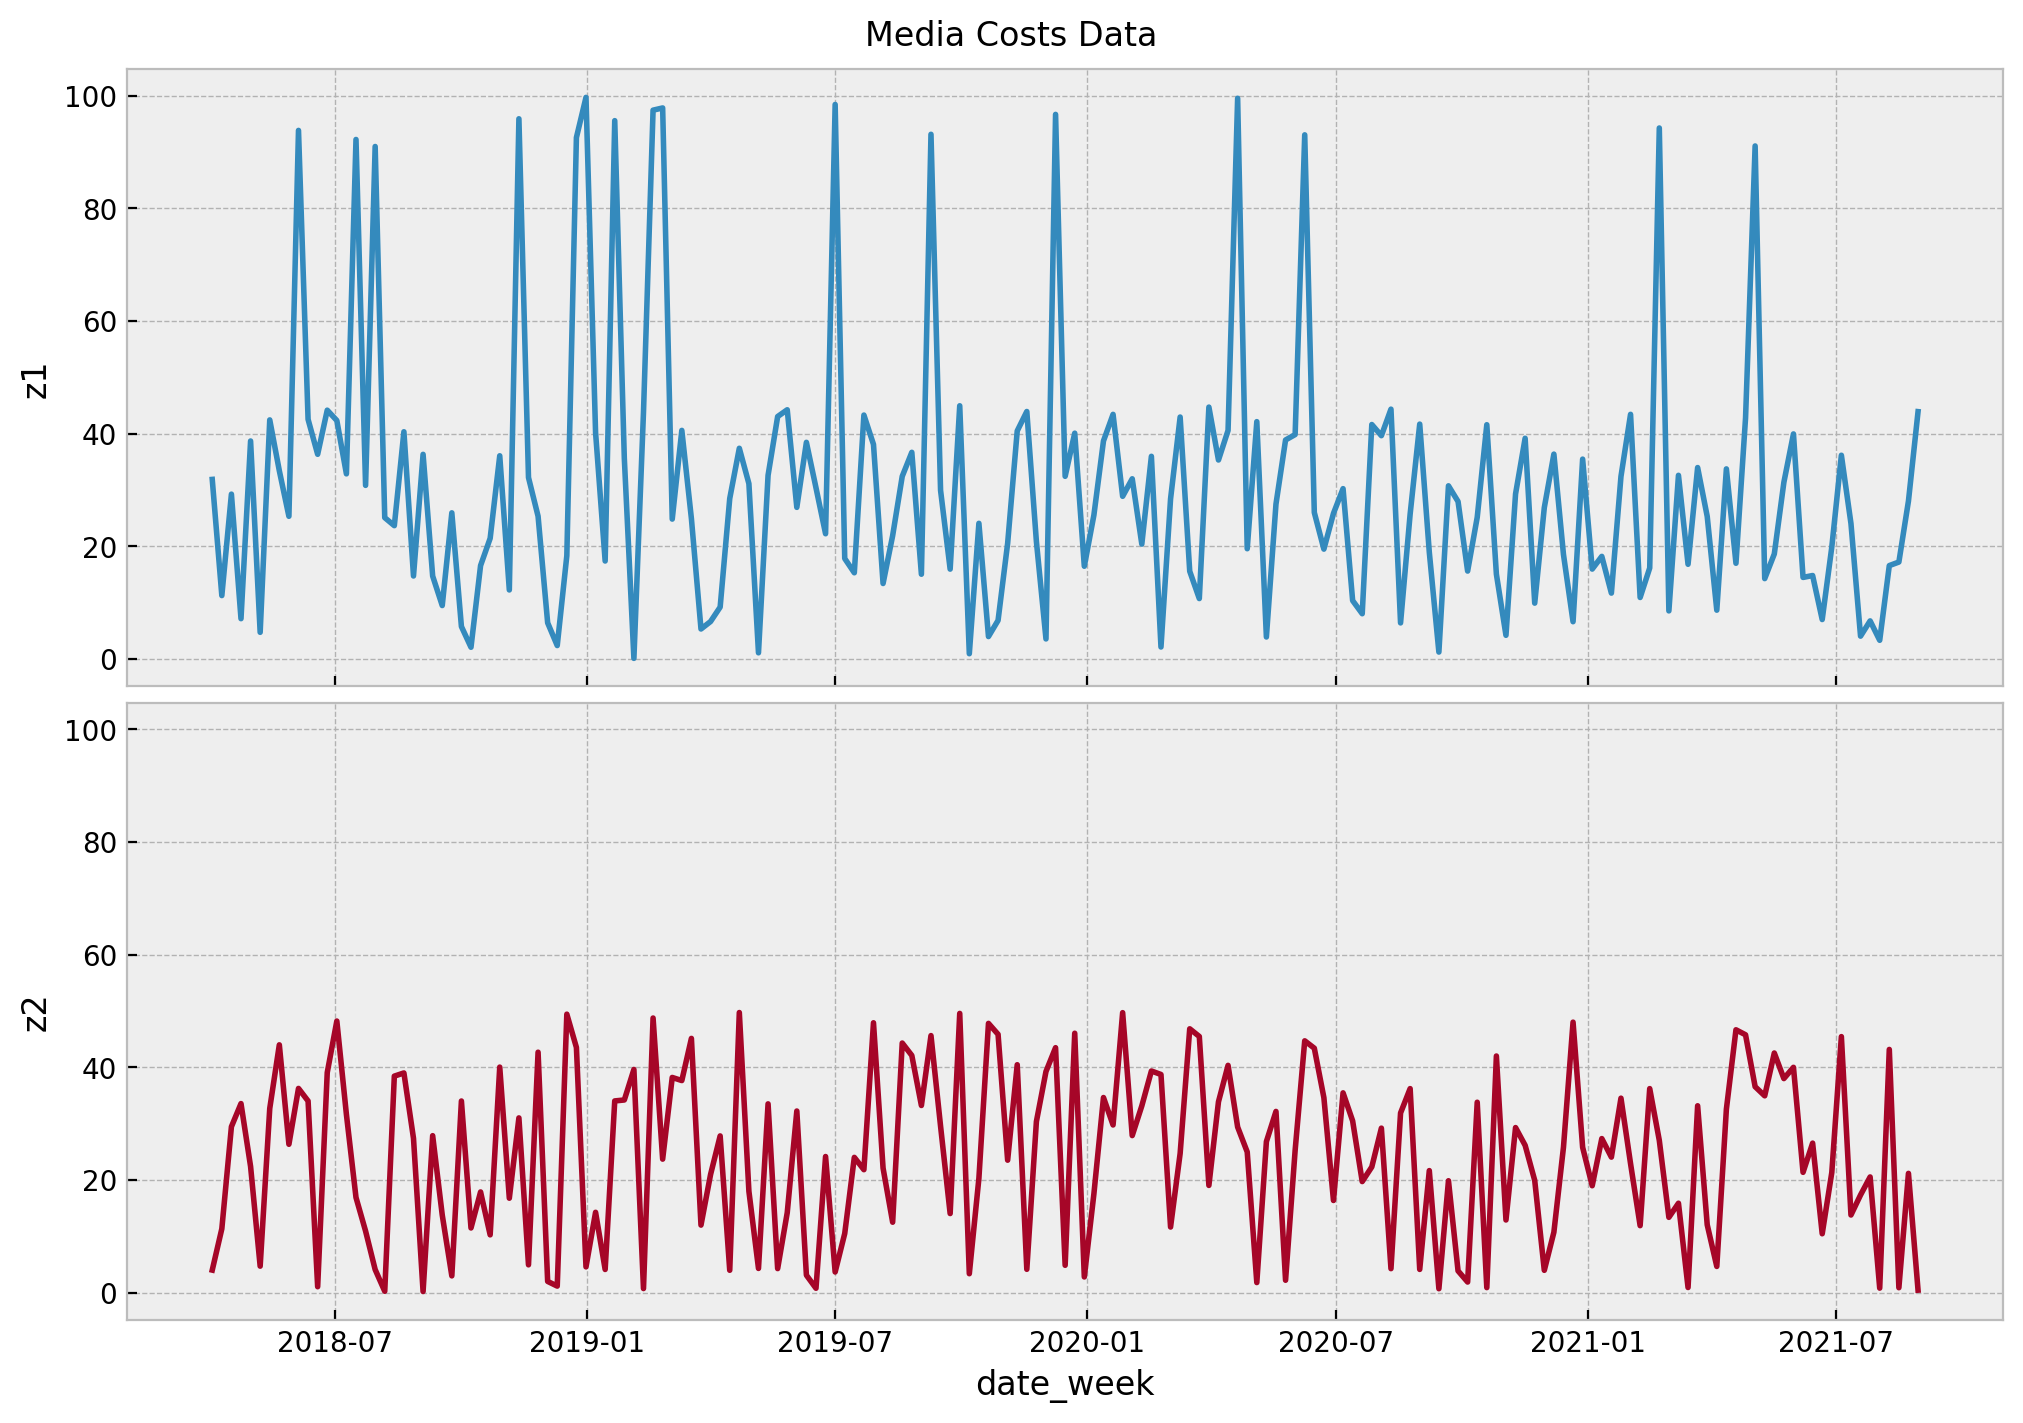

In [3]:
# media data
z1 = rng.uniform(low=0.0, high=1.0, size=n)
df["z1"] = 100 * np.where(z1 > 0.9, z1, z1 / 2)

z2 = rng.uniform(low=0.0, high=1.0, size=n)
df["z2"] = 50 * np.where(z2 > 0.2, z2, z2 / 2)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=df, color="C1", ax=ax[1])
fig.suptitle("Media Costs Data");

- Effect Signal

In [4]:
# scale features
z1_scaler = MaxAbsScaler()
z2_scaler = MaxAbsScaler()

df["z1_scaled"] = z1_scaler.fit_transform(X=df[["z1"]])
df["z2_scaled"] = z2_scaler.fit_transform(X=df[["z2"]])

# apply geometric adstock transformation
alpha1: float = 0.35
alpha2: float = 0.2

df["z1_adstock"] = (
    geometric_adstock(
        x=df["z1_scaled"].to_numpy(), alpha=alpha1, l_max=12, normalize=True
    )
    .eval()
    .flatten()
)

df["z2_adstock"] = (
    geometric_adstock(
        x=df["z2_scaled"].to_numpy(), alpha=alpha2, l_max=12, normalize=True
    )
    .eval()
    .flatten()
)

# apply saturation transformation
lam1: float = 2
lam2: float = 1.5

df["z1_adstock_saturated"] = logistic_saturation(
    x=df["z1_adstock"].to_numpy(), lam=lam1
).eval()

df["z2_adstock_saturated"] = logistic_saturation(
    x=df["z2_adstock"].to_numpy(), lam=lam2
).eval()

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1_scaled", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2_scaled", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed");

### Trend \& Seasonal Components

In [ ]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = - np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5) 
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C4", label="trend", data=df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C6", label="seasonality", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel=None);

### Control Variables

In [ ]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

### Target Variable

In [ ]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.3, size=n)

df["y"] = 1_000 * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + df["z1_adstock_saturated"]
    + df["z2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)");

---

# Part II: Modeling

In [ ]:
columns_to_keep = [
    "date_week",
    "y",
    "z1",
    "z2",
    "event_1",
    "event_2",
]

fourier_modes = generate_fourier_modes(
    periods=df["date_week"].dt.dayofyear / 365.25,
    n_order=2
)

data_df = pd.concat([df[columns_to_keep], fourier_modes], axis=1)

data_df.head()

In [ ]:
mmm = DelayedSaturatedMMM(
    data_df=data_df,
    target_column="y",
    date_column="date_week",
    channel_columns=["z1", "z2"],
    control_columns=[
        "event_1",
        "event_2",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
)

In [ ]:
pm.model_to_graphviz(model=mmm.model)

In [ ]:
mmm.plot_prior_predictive();

In [ ]:
mmm.fit(target_accept=0.9, chains=4, draws=2_000, random_seed=rng)

In [ ]:
az.summary(data=mmm.fit_result, var_names=["intercept", "beta_channel", "alpha",  "lam", "sigma"])

In [ ]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [ ]:
mmm.plot_posterior_predictive(original_scale=True);

In [ ]:
fig = mmm.plot_channel_parameter(param_name="alpha")
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

In [ ]:
fig = mmm.plot_channel_parameter(param_name="lam")
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

In [ ]:
mmm.plot_components_contributions();

In [ ]:
mmm.plot_channel_contribution_share_hdi();

In [ ]:
mmm.plot_contribution_curves();